In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import d1_riskkit_3101 as d1
from pypfopt import risk_models
from pypfopt import expected_returns

from datetime import datetime
%matplotlib inline

# Importering og filtrering af data

 ### Data for aktier og obligationer

In [2]:
d1_data = pd.read_excel("Data/bondsandstocks_data.xlsx",
                      header=0, index_col=0, parse_dates=True)
d1_data = d1_data['1973-01-31':'2020-12-31']

In [3]:
# Her sættes værdi lig sidste business dag i måneden
mnd_data = d1_data.resample('BMS').last()

In [4]:
# Beregning af log afkast
mnd_afkast = np.log(mnd_data/mnd_data.shift(1)).dropna()

In [5]:
# Her ændres datoformat til år og måned
mnd_afkast.index = mnd_afkast.index.to_period('M')

In [6]:
mnd_afkast.columns = ['Obligationer', 'Aktier']

## Renter

### Risikofri rente 

In [7]:
rf_data= pd.read_excel("Data/risikofri_rente.xlsx",
                      header=0, index_col=0, parse_dates=True)

In [8]:
rf_år = rf_data['1973-01-31':'2020-12-31']/100

In [9]:
rf_måned = (1+rf_år)**(1/12)-1

In [10]:
# Her sættes værdi lig sidste business dag i måneden
mnd_rf = rf_måned.resample('BMS').last()

In [11]:
# Her ændres datoformat til år og måned
mnd_rf.index = mnd_rf.index.to_period('M')

In [12]:
mnd_rf.columns = ['Risikofri Rente']
mnd_rf = mnd_rf['1973-02':]

### Lånerente

In [13]:
r_lån_data= pd.read_excel("Data/fed_funds.xlsx",
                      header=0, index_col=0, parse_dates=True)

In [14]:
r_lån_år = r_lån_data['1973-01-31':'2020-12-31']/100

In [15]:
r_lån_mnd = (1+r_lån_år)**(1/12)-1

In [16]:
# Her sættes værdi lig sidste business dag i måneden
mnd_lån = r_lån_mnd.resample('BMS').last()

In [17]:
# Her ændres datoformat til år og måned
mnd_lån.index = mnd_lån.index.to_period('M')

In [18]:
# Her navngives kolonner
mnd_lån.columns = ['Lånerente']
mnd_lån = mnd_lån['1973-02':]

## Graf over udvikling i renteniveauer 1973-2020

<AxesSubplot:title={'center':'Udvikling i renteniveauer 1973-2020'}, xlabel='Date'>

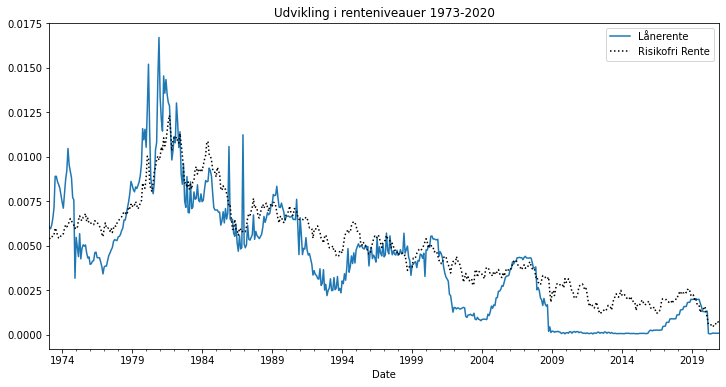

In [19]:
akse = mnd_lån.plot(figsize=(12,6), title = 'Udvikling i renteniveauer 1973-2020')
mnd_rf.plot(ax=akse, style="k:")

# Graf og statistik over prisudvikling over tid for aktier og obligationer


<AxesSubplot:title={'center':'Prisudvikling over tid for aktier og obligationer 1973-2020'}, xlabel='Date'>

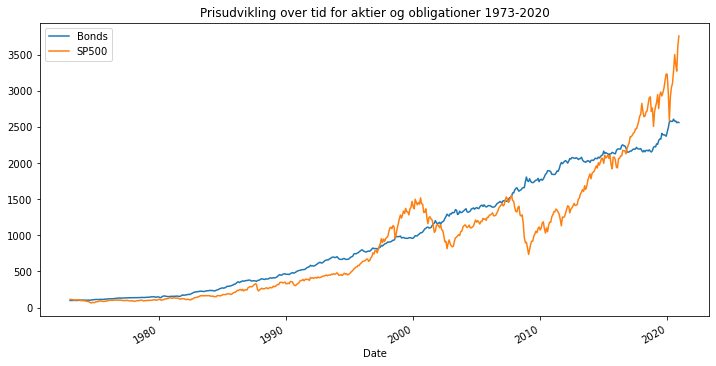

In [20]:
mnd_data.plot(figsize = (12,6), title = 'Prisudvikling over tid for aktier og obligationer 1973-2020')

### Plot af log afkast

In [21]:
#plt.hist(mnd_afkast['Aktier'].dropna(), bins=75, density=False)
#plt.show()

In [22]:
#plt.hist(mnd_afkast['Obligationer'].dropna(), bins=75, density=False)
#plt.show()

In [23]:
# Statistik på et aggregeret niveau for perioden 1973 - 2020
risikofri_rente = np.array(mnd_rf)
akt_obl_stats = d1.stats(mnd_afkast, riskfree_rate=risikofri_rente)
akt_obl_stats

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Obligationer,0.068676,0.050757,0.137898,-0.076841
Aktier,0.062073,0.154740,0.003979,-0.568764


# Konstruering af porteføljer

### Aktie portefølje bestående af S&P500

In [24]:
pf_aktie = pd.DataFrame({'Aktier': mnd_afkast['Aktier']})

### Traditionel 60/40 portefølje

In [25]:
# Her antages det at der rebalanceres månedligt
pf_6040 = 0.6*mnd_afkast['Aktier'] + 0.4*mnd_afkast['Obligationer']

In [26]:
pf_6040 = pd.DataFrame({'60/40 portefølje': pf_6040})

## Funktioner til at finde optimale RP vægte og risikobidrag

In [44]:
from scipy.optimize import minimize

# Funktion der finder de optimale Risk Parity vægte 
def optimale_rp_vægte(afkast):
    """
    Denne funktion finder de optimale Risk Parity vægte, 
    givet en tidsserie med månedlige afkast.
    Der anvendes et rullende 5-årigt estimationsvindue, svarende til 60 perioder
    """  
    n_aktiver = afkast.shape[1]
    optimale_rul_rp_vægte = pd.DataFrame().reindex_like(afkast)
    optimale_rul_rp_vægte.columns = ['Vægt obl.', 'Vægt akt.']
    datoer = afkast.index
    n_steps = len(datoer)
    rp_vægte = 0
    
    for step in range(n_steps):
        if step >= 60:
            cov_rul = afkast.iloc[step-60:step].cov()
            rp_vægte = target_risk_contributions(1/n_aktiver, cov_rul, init_guess=optimale_rul_rp_vægte.iloc[step-1])
        else:
            optimale_rul_rp_vægte.iloc[step] = 1/n_aktiver            
        optimale_rul_rp_vægte.iloc[step] = rp_vægte      
        
    return optimale_rul_rp_vægte.iloc[60:n_steps] # Returnerer de optimale vægte, hvor N/A værdier er fjernet

def target_risk_contributions(target_risk, cov, init_guess):
    """
    Returnerer de porteføljevægte, der sikrer at risikobidraget for
    det enkelte aktiv er så tæt på target risk contribution som muligt,
    givet en kovariansmatrice.
    init_guess anvendes som gæt i funktionen msd_risk
    """
    n = cov.shape[0] # antal aktiver
    bounds = ((0.0, 1.0),) * n # Vægte skal ligge mellem 0 og 1
    
    # Begrænsning, vægte skal summe til 1
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returnerer Mean Squared Difference mellem de faktiske risikobidrag og
        det ønskede risikobidrag.
        Initial guess sættes lig værdien forrige periode
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


def risk_contribution(weights,cov):
    """
    Beregner risikobidrag i procent af den samlede portefølje volatilitet,
    givet vægte og en kovariansmatrice
    """
    total_portfolio_vol =  (weights.T @ cov @ weights)**0.5
    
    # Marginal contribution of each asset
    marginal_contrib = cov@weights
    
    # Risk contribution for each asset
    risk_contrib = np.multiply(marginal_contrib,weights.T)/total_portfolio_vol
    risk_contrib_pct = risk_contrib/total_portfolio_vol
    return risk_contrib_pct


In [45]:
opt_vægte = optimale_rp_vægte(mnd_afkast)

<AxesSubplot:xlabel='Date'>

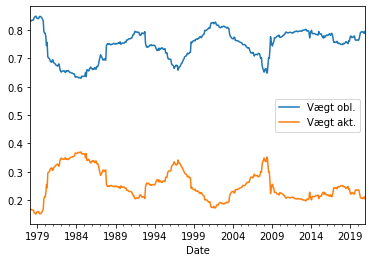

In [46]:
opt_vægte.plot()

### Validering af risikobidrag

In [47]:
def r_bidrag(w, cov):
    """
    Funktion der returnerer en DataFrame med det procentvise risikobidrag
    for hvert aktiv, givet tidsserier med vægte og kovariansmatricer
    """
    datoer = w.index
    n_steps = len(datoer)
    risiko_b = pd.DataFrame().reindex_like(w)
    risiko_b.columns = ['RB obl.', 'RB akt.']
    rb = 0
    for step in range(n_steps):
        # For cov ganges step med antal aktiver, for at få alle rækker i kovariansmatricen med
        rb = risk_contribution(w.iloc[step].ravel(), cov.iloc[step*2:step*2+2]) 
        risiko_b.iloc[step] = rb.ravel()      
    return risiko_b

In [48]:
# Kovarians matrice med 5 års rullende vindue - til validering af risikobidrag
cov_rul = mnd_afkast.rolling(60).cov()
cov_rul.index.names = ['Date', 'Aktiv']
cov_test = cov_rul.iloc[120:] # Her fjernes de første 60 måneder, da de har NaN værdier

In [49]:
risiko_bidrag = r_bidrag(opt_vægte, cov_test)
risiko_bidrag.head()

,RB obl.,RB akt.
Date,,
1978-02,0.499080,0.500920
1978-03,0.497944,0.502056
1978-04,0.491757,0.508243
1978-05,0.500743,0.499257
1978-06,0.501198,0.498802


<AxesSubplot:xlabel='Date'>

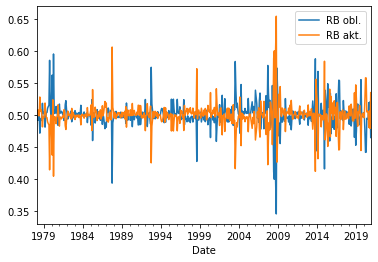

In [50]:
risiko_bidrag.plot()

<AxesSubplot:xlabel='Date'>

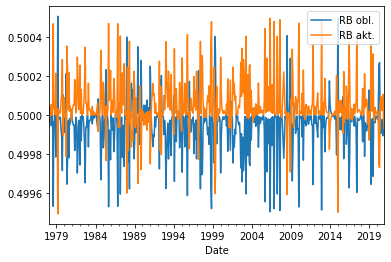

In [52]:
cov_test2 = cov_rul.iloc[118:]
risiko_bidrag2 = r_bidrag(opt_vægte, cov_test2)
risiko_bidrag2.plot()

## Beregninger nedenfor skal opdateres, når optimering virker

### Risk Parity Ugearet - skal opdateres

In [53]:
# Her afgrænses test perioden, således at den ikke inkluderer estimationsperioden
afkast_aktiver = mnd_afkast['1978-02':'2020-12']

In [54]:
# Stats for den ugearede Risk Parity portefølje
afkast_rp_u = opt_vægte.iloc[:,0] * afkast_aktiver.iloc[:,0]+opt_vægte.iloc[:,1] * afkast_aktiver.iloc[:,1]
afkast_rp_u = pd.DataFrame({'Risk Parity Ugearet afkast': afkast_rp_u})
d1.stats(afkast_rp_u['1983-02':], mnd_rf['1983-02':]['Risikofri Rente'])

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Risk Parity Ugearet afkast,0.070641,0.05187,0.328418,-0.12419


<AxesSubplot:xlabel='Date'>

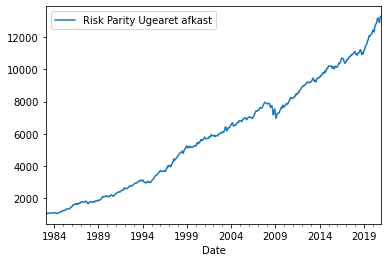

In [55]:
# Plot af Wealth Index
wi_rp_u_83 = 1000*(1+afkast_rp_u['1983-02':]).cumprod()
wi_rp_u_83.plot()

In [56]:
# Tidligere RP beregninger - slet evt
w_rp_ug = d1.optimale_rp_vægte(mnd_afkast)
afkast_rp_ug = w_rp_ug.iloc[:,0] * afkast_aktiver.iloc[:,0]+w_rp_ug.iloc[:,1] * afkast_aktiver.iloc[:,1]
afkast_rp_ug = pd.DataFrame({'Risk Parity Ugearet afkast': afkast_rp_ug})

## Risk Parity Gearet - skal opdateres

$$ w_{a} * R_{p} + (1 - w_{a}) * r_{borrowing} $$

In [57]:
# Her samles RP ugearet og lånerente i en DataFrame
rp_aktiver = pd.DataFrame({'Risk Parity Ugearet afkast': afkast_rp_ug['Risk Parity Ugearet afkast'], 'Lånerente': mnd_lån['1978-02':'2020-12']['Lånerente']})

In [58]:
def target_risk_lev(target_vol, cov):
    
    n = cov.shape[0] # n is the number of assets
    init_guess = np.repeat(1/n, n) # Initial guess is 1/n per asset
    bounds = ((-5.0, 5.0),) * n # an N-tuple of 2-tuples!
    
    #Constraint
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights)-1
    }    
    
    # Objective function
    def objective(weights, target_vol, cov):
        portfolio_vol = np.dot(np.dot(weights.T, cov), weights)**0.5
        return ((portfolio_vol - target_vol)**2)
    
    weights = minimize(objective, init_guess, 
                       args=(target_vol, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,), 
                       bounds=bounds)
            
    return weights.x


def target_risk(samlet_afkast, target_volatilitet):

    vægte = pd.DataFrame(index=samlet_afkast.index, columns=np.arange(2))
    vægte.columns = ['Vægt RP ugearet.', 'Vægt Lånerente']
    datoer = samlet_afkast.index
    n_steps = len(datoer)
    rp_g_vægte = 0
    
    for step in range(n_steps):
        if step >= 60:
            cov_rul = samlet_afkast.iloc[step-60:step].cov()*12
            rp_g_vægte = target_risk_lev(target_volatilitet, cov_rul)
        
        vægte.iloc[step] = rp_g_vægte      
        
    return vægte.iloc[60:n_steps]



In [59]:
w_rp_g = target_risk(rp_aktiver, 0.1)

In [60]:
afkast_rp_g = w_rp_g.iloc[:,0] * rp_aktiver['1983-02':'2020-12'].iloc[:,0]+w_rp_g.iloc[:,1] * rp_aktiver['1983-02':'2020-12'].iloc[:,1]
afkast_rp_g = pd.DataFrame({'Risk Parity Gearet afkast': afkast_rp_g})

# Afgrænsning til testperiode

In [61]:
# Aktier
pf_aktie = pf_aktie['1983-02':'2020-12']

In [62]:
# 60/40
pf_6040 = pf_6040['1983-02':'2020-12']

In [63]:
# Risk Parity ugearet
pf_rp_u = afkast_rp_ug['1983-02':'2020-12']

In [64]:
# Risk Parity gearet
pf_rp_g = afkast_rp_g

# Wealth Index - skal opdateres

In [65]:
pf_afkast = pd.DataFrame({'Aktie portefølje': pf_aktie['Aktier'], '60/40 portefølje': pf_6040['60/40 portefølje'], 'Risk Parity Ugearet': pf_rp_u['Risk Parity Ugearet afkast'],'Risk Parity Gearet': pf_rp_g['Risk Parity Gearet afkast']})

In [66]:
wi = 1000*(1+pf_afkast).cumprod()

<AxesSubplot:title={'center':'Wealth Index for porteføljer 1983-2020'}>

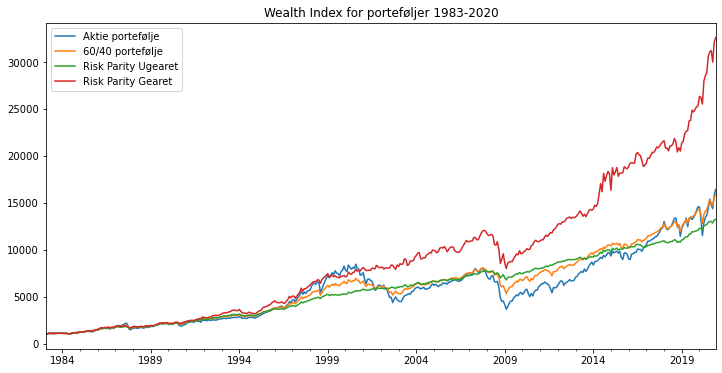

In [67]:
wi.plot(figsize=(12,6), title = 'Wealth Index for porteføljer 1983-2020')

## Portefølje statistik

In [68]:
risikofri_rente = np.array(mnd_rf['1983-02':])

In [69]:
def sharpe_ratio_rf(r, riskfree_rate, periods_per_year):
    """
    Beregner Sharpe Ratio med en timeseries for den risikofri rente
    """
    excess_ret = r.subtract(riskfree_rate, axis=0)
    ann_ex_ret = d1.annualize_rets(excess_ret, periods_per_year=12)
    ann_vol = d1.annualize_vol(r, periods_per_year=12)
    return ann_ex_ret/ann_vol

In [70]:
d1.stats(pf_afkast, risikofri_rente)

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Aktie portefølje,0.076577,0.151487,0.149334,-0.568764
60/40 portefølje,0.075679,0.091990,0.237123,-0.338670
Risk Parity Ugearet,0.070478,0.053511,0.315435,-0.124188
Risk Parity Gearet,0.096258,0.101966,0.406179,-0.338753


In [71]:
risiko_bidrag.to_excel('risiko_bidrag.xlsx')

In [72]:
cov_test.to_excel('cov_rul.xlsx')

In [73]:
opt_vægte.to_excel('opt_vægte.xlsx')

# Performance under kriser - skal opdateres
Ref til https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions

OBS: Det er artiklen 'Fact and fiction about low risk investing' fra The Journal of Portfolio management' vi har brugt som udgangspunkt for periodeafgrænsning

In [74]:
# Fact and fiction perioder
p_1987_1987 = pf_afkast['1987-08':'1987-11']
p_2000_2002 = pf_afkast['2000-08':'2002-09']
p_2007_2009 = pf_afkast['2007-10':'2009-02']
p_2020_2020 = pf_afkast['2020-01':'2020-03']

In [75]:
# Beregning af akkumulerede afkast
ak_1987_1987 = (1+p_1987_1987).prod()-1
ak_2000_2002 = (1+p_2000_2002).prod()-1
ak_2007_2009 = (1+p_2007_2009).prod()-1
ak_2020_2020 = (1+p_2020_2020).prod()-1

In [76]:
tabel = pd.DataFrame({ '1987-08 til 1987-11': ak_1987_1987, '2000-08 til 2002-09': ak_2000_2002, '2007-10 til 2009-02': ak_2007_2009, '2020-01 til 2020-03': ak_2020_2020})
tabel.index.names = ['Akkumuleret afkast']
tabel

,1987-08 til 1987-11,2000-08 til 2002-09,2007-10 til 2009-02,2020-01 til 2020-03
Akkumuleret afkast,,,,
Aktie portefølje,-0.306520,-0.454601,-0.541482,-0.211071
60/40 portefølje,-0.180633,-0.225148,-0.330759,-0.100399
Risk Parity Ugearet,-0.080917,0.087047,-0.110986,0.008201
Risk Parity Gearet,-0.114877,0.095662,-0.320923,0.008609


# Nyt forsøg med Bai et al

In [77]:
# -------------------- Forsøg på optimering med kovarianser som input

from scipy.optimize import minimize

# Funktion der finder de optimale Risk Parity vægte 
def optimale_rp_vægte2(cov):
    """
    Denne funktion finder de optimale Risk Parity vægte, 
    givet en tidsserie med månedlige afkast.
    Der anvendes et rullende 5-årigt estimationsvindue, svarende til 60 perioder
    """  
    n_aktiver = cov.shape[1]
    datoer = cov.index.get_level_values('Date')
    optimale_rul_rp_vægte = pd.DataFrame(columns = ['Vægt obl.', 'Vægt akt.'], index=datoer)
    n_steps = len(datoer)
    rp_vægte = 0
    

    for step in range(n_steps):
        rp_vægte = target_risk_contributions2(cov.iloc[step*n_aktiver:step*n_aktiver+n_aktiver], init_guess=optimale_rul_rp_vægte.iloc[step-1])              
        optimale_rul_rp_vægte.iloc[step] = rp_vægte      
        
    return optimale_rul_rp_vægte

def target_risk_contributions2(cov, init_guess):
    """
    Returnerer de porteføljevægte, der sikrer at risikobidraget for
    det enkelte aktiv er så tæt på target risk contribution som muligt,
    givet en kovariansmatrice.
    init_guess anvendes som gæt i funktionen msd_risk
    """
    n = cov.shape[1] # antal aktiver
    bounds = ((0.0, 1.0),) * n # Vægte skal ligge mellem 0 og 1
    
    # Begrænsning, vægte skal summe til 1 - bruges ikke
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    beta=1
    def msd_risk(weights, cov, beta=1):
        """
        Returnerer Mean Squared Difference mellem de faktiske risikobidrag og
        det ønskede risikobidrag.
        Initial guess sættes lig værdien forrige periode
        """
        portefølje_vol = np.dot(np.dot(weights.T, cov), weights)**0.5
        antal_aktiver = cov.shape[1]
        risiko_budget = portefølje_vol/antal_aktiver 
        res = 0.5 * np.dot(np.dot(weights, cov), weights.T) - sum(risiko_budget * np.log(weights*beta))
        return res
    
    weights = minimize(msd_risk, init_guess,
                       args=(cov, beta), method='SLSQP',
                       options={'disp': False},
                       #constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

In [78]:
nye_opt_vægte = optimale_rp_vægte2(cov_test)

ValueError: shapes (2,) and (0,2) not aligned: 2 (dim 0) != 0 (dim 0)

In [79]:
# --------------------- Opdateret ud fra Bai et al, formel (13) - med afkast som input

from scipy.optimize import minimize

# Funktion der finder de optimale Risk Parity vægte 
def optimale_rp_vægte3(afkast):
    """
    Denne funktion finder de optimale Risk Parity vægte, 
    givet en tidsserie med månedlige afkast.
    Der anvendes et rullende 5-årigt estimationsvindue, svarende til 60 perioder
    """  
    n_aktiver = afkast.shape[1]
    optimale_rul_rp_vægte = pd.DataFrame().reindex_like(afkast)
    optimale_rul_rp_vægte.columns = ['Vægt obl.', 'Vægt akt.']
    datoer = afkast.index
    n_steps = len(datoer)
    rp_vægte = 1/n_aktiver
    #cov = afkast.cov()
    
    for step in range(n_steps):
        if step >= 60:
            cov_rul = afkast.iloc[step-60:step].cov()
            rp_vægte = target_risk_contributions3(cov_rul, init_guess=optimale_rul_rp_vægte.iloc[step-1])
        else:
            optimale_rul_rp_vægte.iloc[step] = 1/n_aktiver            
        optimale_rul_rp_vægte.iloc[step] = rp_vægte      
        
    return optimale_rul_rp_vægte.iloc[60:n_steps] # Returnerer de optimale vægte, hvor N/A værdier er fjernet

def target_risk_contributions3(cov, init_guess):
    """
    Returnerer de porteføljevægte, der sikrer at risikobidraget for
    det enkelte aktiv er så tæt på target risk contribution som muligt,
    givet en kovariansmatrice.
    init_guess anvendes som gæt i funktionen msd_risk
    """
    n = cov.shape[0] # antal aktiver
    bounds = ((0.0, 1.0),) * n # Vægte skal ligge mellem 0 og 1
    beta=1
    # Begrænsning, vægte skal summe til 1
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, cov, beta=1):
        """
        Returnerer Mean Squared Difference mellem de faktiske risikobidrag og
        det ønskede risikobidrag.
        Initial guess sættes lig værdien forrige periode
        """
        #w_contribs = risk_contribution(weights, cov)
        portefølje_vol = np.dot(np.dot(weights.T, cov), weights)**0.5
        antal_aktiver = cov.shape[1]
        risiko_budget = portefølje_vol/antal_aktiver 
        res = 0.5 * np.dot(np.dot(weights, cov), weights) - sum(risiko_budget * np.log(weights*beta))

        return res
    
    weights = minimize(msd_risk, init_guess,
                       args=(cov, beta), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


def risk_contribution(weights,cov):
    """
    Beregner risikobidrag i procent af den samlede portefølje volatilitet,
    givet vægte og en kovariansmatrice
    """
    total_portfolio_vol =  (weights.T @ cov @ weights)**0.5
    
    # Marginal contribution of each asset
    marginal_contrib = cov@weights
    
    # Risk contribution for each asset
    risk_contrib = np.multiply(marginal_contrib,weights.T)/total_portfolio_vol
    risk_contrib_pct = risk_contrib/total_portfolio_vol
    return risk_contrib_pct

In [80]:
test3 = optimale_rp_vægte3(mnd_afkast)

<AxesSubplot:xlabel='Date'>

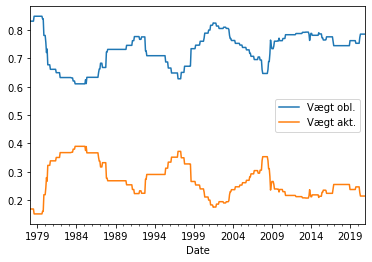

In [81]:
test3.plot()

In [82]:
def r_bidrag3(w, cov):
    """
    Funktion der returnerer en DataFrame med det procentvise risikobidrag
    for hvert aktiv, givet tidsserier med vægte og kovariansmatricer
    """
    datoer = w.index
    n_steps = len(datoer)
    risiko_b = pd.DataFrame().reindex_like(w)
    risiko_b.columns = ['RB obl.', 'RB akt.']
    rb = 0
    for step in range(n_steps):
        # For cov ganges step med antal aktiver, for at få alle rækker i kovariansmatricen med
        rb = risk_contribution(w.iloc[step].ravel(), cov.iloc[step*2:step*2+2]) 
        risiko_b.iloc[step] = rb.ravel()      
    return risiko_b

In [89]:
cov_test3 = cov_rul.iloc[118:] # Her fjernes de første 60 måneder, da de har NaN værdier

In [90]:
r_bidrag = r_bidrag3(test3, cov_test3)

<AxesSubplot:xlabel='Date'>

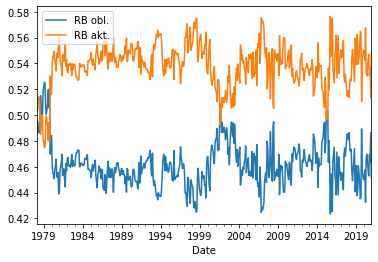

In [91]:
r_bidrag.plot()